# Libraries and Global Settings

In [1]:
import pandas as pd  # work with Pandas dataframes

from keras.optimizers import Adam, RMSprop, SGD, Adadelta, Adagrad, Adamax, Nadam
from keras.layers.core import Dense, Activation, Dropout
from keras.models import Sequential
from keras import layers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import LeakyReLU, Bidirectional, LSTM

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV, ParameterGrid

import seaborn as sns 
# Visualizations
from matplotlib import pyplot as plt
%matplotlib inline

import mlflow
import mlflow.sklearn

import mlflow.keras
mlflow.keras.autolog()

import warnings  # Funktionalität zur Unterdrückung von Warnungen
warnings.filterwarnings('ignore')

Using TensorFlow backend.


# Importing Data

First of all we import the data which were generated through the preprocess described in another notebook.  
We generate the dataframe `df_for_ML`.  
The date is parsed with the help of folling parse function.


In [2]:
def dateparse(x):
    return pd.datetime.strptime(x, '%Y-%m-%d')

In [3]:
df_for_ML = pd.read_csv('df_for_ML.csv',
                        parse_dates=['Datum'],
                        date_parser=dateparse)

In [4]:
df_for_ML.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7458 entries, 0 to 7457
Data columns (total 9 columns):
Datum           7458 non-null datetime64[ns]
Temp            7458 non-null float64
WG              7458 non-null float64
WR              7458 non-null float64
Druck           7458 non-null float64
NO              7458 non-null float64
NO2             7458 non-null float64
Niederschlag    7458 non-null float64
PM10            7458 non-null float64
dtypes: datetime64[ns](1), float64(8)
memory usage: 524.5 KB


In [5]:
df_for_ML = df_for_ML.sort_values(by=['Datum'], axis=0, ascending=True)
df_for_ML

,Datum,Temp,WG,WR,Druck,NO,NO2,Niederschlag,PM10
0,2000-01-01,3.718,1.959896,234.922917,991.80,17.6266,24.236,3.5892,11.3772
1,2000-01-02,3.848,2.172912,222.511250,996.90,14.2886,28.698,3.5212,12.3972
2,2000-01-03,1.463,2.295208,220.181250,996.20,19.0638,35.336,0.8398,19.9480
3,2000-01-04,4.934,3.574979,220.885417,989.90,8.2660,24.210,1.4894,11.4780
4,2000-01-05,6.917,2.237208,220.554167,989.70,11.3496,26.208,4.3200,12.9260
...,...,...,...,...,...,...,...,...,...
7452,2020-05-27,17.300,1.700000,212.000000,1000.09,6.1000,21.700,0.0000,12.1060
7453,2020-05-28,17.300,2.400000,28.000000,996.45,4.2000,23.500,0.0000,13.9400
7454,2020-05-29,16.200,2.200000,129.000000,993.43,2.8000,18.700,0.0000,21.6300
7455,2020-05-30,15.900,2.400000,27.000000,989.46,2.4000,18.400,0.0000,13.1080


# Modeling

## Data Preparation

### Selection of Timeframe

We decided only to analyze and predict date where we have not imputed too many data for missing values.   
So we can expect a higher quality of our prediction model.

In [6]:
startDate = "2003-01-01"
endDate = "2018-12-31"

In [7]:
df_for_ML = df_for_ML[(df_for_ML["Datum"] >= startDate)
                      & (df_for_ML["Datum"] <= endDate)]

In [8]:
df_for_ML.tail()

,Datum,Temp,WG,WR,Druck,NO,NO2,Niederschlag,PM10
6935,2018-12-27,0.8,0.8,21.5,995.43,54.557,43.7,0.0,18.4
6936,2018-12-28,1.3,0.8,256.0,996.84,54.557,38.9,0.0,17.4
6937,2018-12-29,2.4,1.3,230.3,1000.46,11.600,28.0,0.1,11.5
6938,2018-12-30,6.5,2.1,244.0,1000.46,1.300,12.3,0.7,8.4
6939,2018-12-31,6.9,0.7,213.9,1001.15,7.600,21.6,0.9,9.3


### Split Data into Training and Validation Samples

We split the date with train data for periods 2003-2016 and test the models on data for 2017-2018.

In [9]:
splitDate="2016-12-31"

In [10]:
df_train = df_for_ML[df_for_ML["Datum"] <= splitDate]
df_test = df_for_ML[df_for_ML["Datum"] > splitDate]

### Data Scaling

Although we performed the outlier detection in the preprocessing we see that the rainfall has still many values outside the IQR. That is we are performing the `RobustScaler` from Sklearn which is robust to outliers.

Scaling the train data:

In [11]:
df_train_woDate = df_train.drop('Datum', axis=1)
x = df_train_woDate.values  # returns a numpy array
robustScaler = RobustScaler()
x_scaled = robustScaler.fit_transform(x)
df_train_norm = pd.DataFrame(x_scaled)

In [12]:
df_train_norm.describe()

,0,1,2,3,4,5,6,7
count,5115.000000,5115.000000,5115.000000,5115.000000,5115.000000,5115.000000,5115.000000,5115.000000
mean,-0.018887,0.231913,-0.191201,-0.065132,0.318994,0.093558,1.080912,0.135750
std,0.639881,0.885091,0.706613,0.795053,0.803527,0.757731,2.315683,0.759819
min,-1.992288,-1.613262,-2.311302,-2.003989,-0.572506,-1.549712,-0.054030,-1.530163
25%,-0.523749,-0.364726,-0.685935,-0.531915,-0.296542,-0.445213,-0.054030,-0.428263
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.476251,0.635274,0.314065,0.468085,0.703458,0.554787,0.945970,0.571737
max,1.642303,3.145363,1.736575,1.917287,2.078606,2.232065,10.301666,1.922720


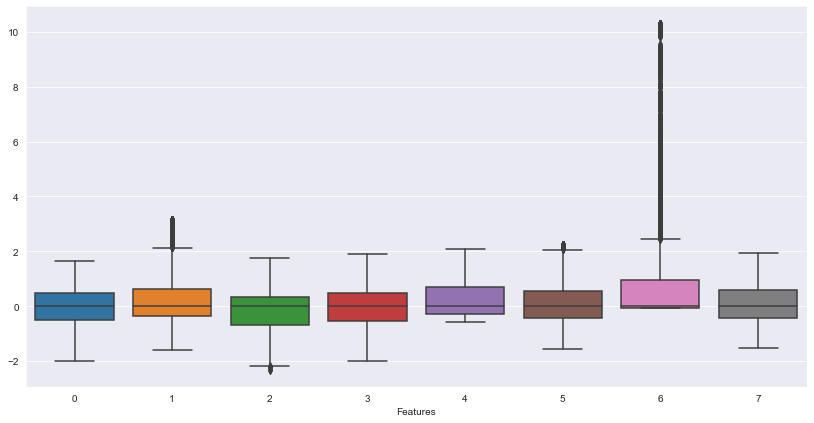

In [13]:
plt.figure(figsize=(14, 7))
sns.set_style("darkgrid")
sns.boxplot(data=df_train_norm)
plt.xlabel("Features")
plt.show()

Scaling the test data:

In [14]:
df_test_woDate = df_test.drop('Datum', axis=1)
x = df_test_woDate.values  # returns a numpy array
robustScaler = RobustScaler()
x_scaled = robustScaler.fit_transform(x)
df_test_norm = pd.DataFrame(x_scaled)

In [16]:
df_test_norm.describe()

,0,1,2,3,4,5,6,7
count,730.000000,730.000000,730.000000,7.300000e+02,730.000000,730.000000,730.000000,7.300000e+02
mean,-0.003986,0.386149,-0.546588,-3.402301e-02,0.416625,0.041931,1.232575,1.740679e-01
std,0.627787,1.006662,2.821312,8.658226e-01,1.036697,0.718378,2.632725,8.637720e-01
min,-1.623246,-1.166667,-8.774603,-2.218910e+00,-0.497132,-1.480799,0.000000,-1.443243e+00
25%,-0.490982,-0.333333,-0.369312,-4.896116e-01,-0.281071,-0.496160,0.000000,-3.908602e-01
50%,0.000000,0.000000,0.000000,6.846520e-15,0.000000,0.000000,0.000000,-9.649399e-17
75%,0.509018,0.666667,0.630688,5.103884e-01,0.718929,0.503840,1.000000,6.091398e-01
max,1.294589,4.777674,6.069841,2.220717e+00,3.667839,2.741997,11.500000,2.828963e+00


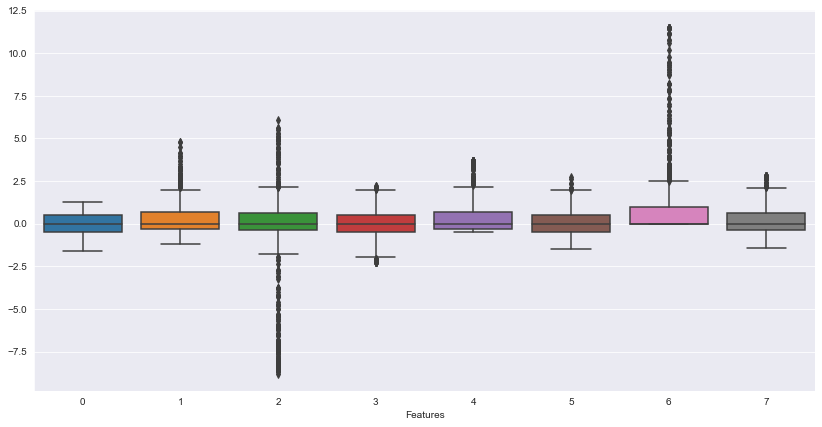

In [17]:
plt.figure(figsize=(14, 7))
sns.set_style("darkgrid")
sns.boxplot(data=df_test_norm)
plt.xlabel("Features")
plt.show()

Now we want to return the column names.

In [18]:
i = 0
dictColumn = {}
for i in range(0, (len(df_test_woDate.columns))):
    dictColumn.update(
        {list(df_test_norm.columns)[i]: list(df_test_woDate.columns)[i]})
    i = i + 1
dictColumn

{0: 'Temp',
 1: 'WG',
 2: 'WR',
 3: 'Druck',
 4: 'NO',
 5: 'NO2',
 6: 'Niederschlag',
 7: 'PM10'}

In [19]:
df_train_norm=df_train_norm.rename(columns=dictColumn)
df_test_norm=df_test_norm.rename(columns=dictColumn)

In [20]:
df_train_norm.head()

,Temp,WG,WR,Druck,NO,NO2,Niederschlag,PM10
0,-0.497606,0.534182,-0.842573,-0.968085,0.854268,-0.388466,0.522287,1.922720
1,-0.030507,2.803730,0.278038,-2.003989,-0.184573,-0.494118,10.301666,-1.098083
2,-0.285835,2.748578,0.298085,-1.904255,-0.096081,-0.384314,1.062584,-0.189196
3,-0.571840,-0.313689,-0.032778,-1.776596,0.474810,0.054902,10.301666,-0.663016
4,-1.144782,0.016070,-0.603272,-0.968085,0.228162,-0.303114,0.234129,-0.073853


### Split Data into Input and Target Data

Define the function to generate featuers and target data on basis of train and test requirements.

In [21]:
def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        targets = y.iloc[i + time_steps]
        Xs.append(v)
        ys.append(targets)
    return np.array(Xs), np.array(ys)

#### Split Data into Input and Target Data for Neural Networks

On basis of the last three weeks we want to predict the target value for particulate.

In [22]:
TIME_STEPS = 21
STEP = 1

X_train, y_train = create_dataset(
    # df_train.drop(columns=['PM10']),
    df_train_norm,
    df_train_norm.PM10,
    TIME_STEPS,
    STEP)

X_test, y_test = create_dataset(
    # df_test.drop(columns=['PM10']),
    df_test_norm,
    df_test_norm.PM10,
    TIME_STEPS,
    STEP)

#### Split Data into Input and Target Data for Baseline Model

On basis of the last day we want to predict the target value for particulate.

In [23]:
TIME_STEPS = 1
STEP = 1

X_train_base, y_train_base = create_dataset(
    # df_train.drop(columns=['PM10']),
    df_train_norm,
    df_train_norm.PM10,
    TIME_STEPS,
    STEP)

X_test_base, y_test_base = create_dataset(
    # df_test.drop(columns=['PM10']),
    df_test_norm,
    df_test_norm.PM10,
    TIME_STEPS,
    STEP)

## Alogrithms Selection

As a simple base line model, we opted for a linear regression that predicts the value of the particulates based on the features including the particulates of the previous day. 

For the final model, we opted for an LSTM neural network that predicts the value of particulate based on the features including the particulates of the previous 21 days. LSTM is traditionaly one of the best approach method for times series forcasting.

## Baseline Models

With the set_experiment we create a new MLFlow project. If already done before, we select this project.

In [24]:
mlflow.set_experiment("Baseline Model AirQualityStuttgart")

INFO: 'Baseline Model AirQualityStuttgart' does not exist. Creating a new experiment


At this point we have to reshape the given features numpay arrey in a compatible shape for the baseline model `linear regression`.

In [25]:
X_train_base = X_train_base.reshape(-1,8) 
X_test_base = X_test_base.reshape(-1,8)

Print the second datarow to compare the value of particulate with the first data row in the `y_train` data set.

In [26]:
X_train_base[1]

array([-0.03050718,  2.8037301 ,  0.27803752, -2.00398936, -0.18457257,
       -0.49411765, 10.30166592, -1.09808315])

First data row in the `y_train` data set.

In [27]:
y_train_base[0]

-1.098083146626836

For the baseline model we use the linear regression.

In [28]:
# Create linear regression object
regr = LinearRegression()
# Train the model using the training sets
regr.fit(X_train_base, y_train_base)

LinearRegression()

The predicted values can be generated as followed:

In [29]:
test_pred = regr.predict(X_test_base)

In [30]:
y_test_base[0:10]

array([ 0.23039722, -0.84551432, -1.44324295, -0.03042982, -0.53034831,
        0.86072923, -0.12823996, -0.54121611, -0.26952127, -1.34543281])

In [31]:
test_pred[0:10]

array([ 1.52565211, -0.1833968 , -0.35470202, -1.31773741,  0.96428124,
       -0.0948241 ,  1.43278755,  0.82098009, -0.10044902,  0.71482584])

The results can be summarized:

In [32]:
print(" Coeffs: \n", regr.coef_)
print("\n Intercept: \n", regr.intercept_)
print("\n R2: \n", regr.score(X_test_base, y_test_base))
print("\n MSE:  \n", mean_squared_error(y_test_base, test_pred))

 Coeffs: 
 [-0.10414092 -0.04563868 -0.11416187  0.08072053 -0.08832656  0.08064271
 -0.01170564  0.57468738]

 Intercept: 
 0.08297945185226491

 R2: 
 0.3635360430729061

 MSE:  
 0.4687049200906185


The metrics of the model and the model itself will be serialized in MLFlow.

For Keras the recording of results, parameters, metrics and models is done by Keras itself. For Sklearn this has to be defined with a code. 

In [33]:
mlflow.log_metric("Intercept", regr.intercept_)
mlflow.log_metric("R2", regr.score(X_test_base, y_test_base))
mlflow.log_metric("MSE", mean_squared_error(y_test_base, test_pred))
mlflow.sklearn.log_model(regr, "model")

Now we plot the residuals for the train data (blue) and the test data (red).

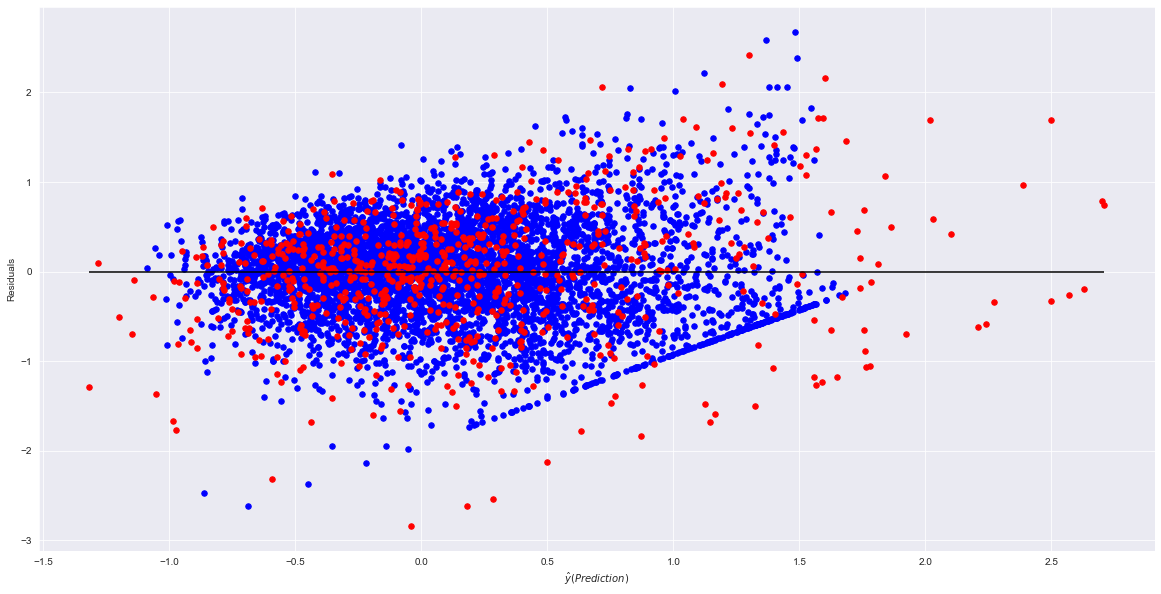

In [34]:
# Residual Plot (Restwert)
train_pred = regr.predict(X_train_base)
test_pred = regr.predict(X_test_base)

min_val = min(min(train_pred), min(test_pred))
max_val = max(max(train_pred), max(test_pred))

plt.figure(figsize=(20,10))
plt.scatter(train_pred, train_pred - y_train_base, color="blue", s=30)
plt.scatter(test_pred, test_pred - y_test_base, color="red", s=30)
plt.hlines(y = 0, xmin =min_val, xmax=max_val)
plt.xlabel("$\hat{y} (Prediction)$")
plt.ylabel("Residuals")
plt.show()

> **Result documentation baseline model:**<br>
The standard deviation of our test dataset is 0.760, the variance is 0.578. The variance is the value that we want to beat with our prediction models. 
We determine for each model the mean squared error (MSE) which will be used to compare with the variance value as benchmark. 
The Baseline Model shows a MSE of 0.468 which is already better then the variance.


With the active_run command we start the recording of the actual Baseline model.

In [35]:
r = mlflow.active_run()
r.info

<RunInfo: artifact_uri='file:///C:/Users/elvir/Documents/Git_Projekte/AirQualityStuttgart/mlruns/1/d832fc2dcf2e4a1780059513f3c87f34/artifacts', end_time=None, experiment_id='1', lifecycle_stage='active', run_id='d832fc2dcf2e4a1780059513f3c87f34', run_uuid='d832fc2dcf2e4a1780059513f3c87f34', start_time=1593529954393, status='RUNNING', user_id='elvir'>

With the end_run command we stop the recording of the actual Baseline model.

In [36]:
mlflow.end_run()

In [37]:
exp = mlflow.get_experiment("1")
exp

<Experiment: artifact_location='file:///C:/Users/elvir/Documents/Git_Projekte/AirQualityStuttgart/mlruns/1', experiment_id='1', lifecycle_stage='active', name='Baseline Model AirQualityStuttgart', tags={}>

In [38]:
exp.name

'Baseline Model AirQualityStuttgart'

## Deep Learning Models

### Vanilla Model

In [101]:
vanilla_model = Sequential()
vanilla_model.add(
    layers.LSTM(units=200,
                return_sequences=False,
                #activation='tanh',
                input_shape=(X_train.shape[1], X_train.shape[2])))
vanilla_model.add(layers.Dense(1))
vanilla_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_4 (LSTM)                (None, 200)               167200    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 201       
Total params: 167,401
Trainable params: 167,401
Non-trainable params: 0
_________________________________________________________________


In [102]:
vanilla_model.compile(optimizer='RMSprop', loss='mse')
vanilla_history = vanilla_model.fit(x=X_train, y=y_train, epochs=10, validation_data=(X_test, y_test))

Train on 5094 samples, validate on 709 samples
Epoch 1/10
5094/5094 [==============================] - 4s 872us/step - loss: 0.3247 - val_loss: 0.5494
Epoch 2/10
5094/5094 [==============================] - 6s 1ms/step - loss: 0.2768 - val_loss: 0.5560
Epoch 3/10
5094/5094 [==============================] - 7s 1ms/step - loss: 0.2710 - val_loss: 0.4545
Epoch 4/10
5094/5094 [==============================] - 6s 1ms/step - loss: 0.2664 - val_loss: 0.4411
Epoch 5/10
5094/5094 [==============================] - 5s 1ms/step - loss: 0.2640 - val_loss: 0.4605
Epoch 6/10
5094/5094 [==============================] - 6s 1ms/step - loss: 0.2599 - val_loss: 0.4551
Epoch 7/10
5094/5094 [==============================] - 5s 1ms/step - loss: 0.2550 - val_loss: 0.4840
Epoch 8/10
5094/5094 [==============================] - 5s 1ms/step - loss: 0.2515 - val_loss: 0.5082
Epoch 9/10
5094/5094 [==============================] - 5s 1ms/step - loss: 0.2465 - val_loss: 0.4964
Epoch 10/10
5094/5094 [==========

In [103]:
print("Minimum validation loss: ", min(vanilla_history.history['val_loss']))

Minimum validation loss:  0.44114019130113596


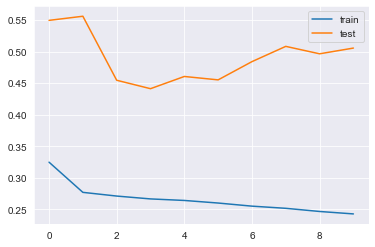

In [104]:
plt.plot(vanilla_history.history['loss'], label='train')
plt.plot(vanilla_history.history['val_loss'], label='test')
plt.legend()
plt.show()

> **Result documentation Vanilla LSTM model:**<br>
The Vanilla LSTM model shows the min MSE of 0.441 which is better than the variance of our testdata (benchmark) and our Baseline model.

### Manual Model Optimaziation

Based on the Vanilla LSTM model we manually develop an better model with the help of a trial and error principle. 

In [105]:
model = Sequential()
model.add(LSTM(units=20, activation = 'sigmoid', return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 20)                2320      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 21        
Total params: 2,341
Trainable params: 2,341
Non-trainable params: 0
_________________________________________________________________


In [106]:
model.compile(optimizer='RMSprop', loss='mse')
history = model.fit(x=X_train, y=y_train, epochs=50, validation_data=(X_test, y_test))

Train on 5094 samples, validate on 709 samples
Epoch 1/50
5094/5094 [==============================] - 2s 365us/step - loss: 0.4842 - val_loss: 0.5376
Epoch 2/50
5094/5094 [==============================] - 1s 240us/step - loss: 0.3838 - val_loss: 0.5132
Epoch 3/50
5094/5094 [==============================] - 1s 267us/step - loss: 0.3520 - val_loss: 0.4942
Epoch 4/50
5094/5094 [==============================] - 1s 249us/step - loss: 0.3345 - val_loss: 0.4753
Epoch 5/50
5094/5094 [==============================] - 1s 282us/step - loss: 0.3167 - val_loss: 0.4666
Epoch 6/50
5094/5094 [==============================] - 2s 322us/step - loss: 0.3176 - val_loss: 0.4552
Epoch 7/50
5094/5094 [==============================] - 2s 339us/step - loss: 0.3169 - val_loss: 0.4507
Epoch 8/50
5094/5094 [==============================] - 2s 297us/step - loss: 0.3125 - val_loss: 0.4466
Epoch 9/50
5094/5094 [==============================] - 2s 333us/step - loss: 0.3082 - val_loss: 0.4490
Epoch 10/50
5094/

In [107]:
print("Minimum validation loss: ", min(history.history['val_loss']))
print("Difference between min Loss and min val_loss: ", min(history.history['val_loss'])-min(history.history['loss']))

Minimum validation loss:  0.40841670084235027
Difference between min Loss and min val_loss:  0.1268826262637449


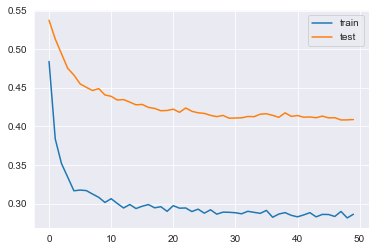

In [108]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Following `optimization steps` are done.  

-----

`Step 1:` ***Number of units for LSTM layer***  

- 50 (min val_loss = 0.418)
- 20 (min val_loss = 0.392)
- 10 (min val_loss = 0.391)
- 5 (min val_loss = 0.410)
- 75 (min val_loss = 0.427)
- 100 (min val_loss = 0.424)
- 120 (min val_loss = 0.437)

*Results:* 

The multiple training with a specific unit amount varies because the initialization values are different each time.  
Anyway we see that a smaller amount of units performs better than a too large amount. 
> We decided to use the unit number ***20***.

-----

`Step 2:` ***Activation function***  

- tanh(min val_loss = 0.392)
- linear (min val_loss = 0.482)
- sigmoid (min val_loss = 0.411)
- relu (min val_loss = 0.488)
- leaky relu (alpha = 0.3) / implemented as an additional layer (min val_loss = 0.413)
- softplus (min val_loss = 0.408)
- selu (min val_loss = 0.467)
- elu (min val_loss = 0.598)

The exponential function does not work in our model (validatons are shown as NaNs).  

The softmax function is a more generalized logistic activation function which is used for multiclass classification.

As the sigmoid and the tanh functions are close we extended the validation with epochs number of 50 for both to get a better picture.  
- sigmoid (min val_loss = 0.384) with epochs = 18
- tanh(min val_loss = 0.407)

*Results:* 

The multiple training with a specific unit amount varies because the initialization values are different each time.  
Anyway we see that a smaller amount of units performs better than a too large amount. 

> We decided to use the ***Sigmoid*** function.

-----

`Step 3:` ***Batch Sizes***  

- 500 (min val_loss = 0.548)
- 100 (min val_loss=0.417)
- 10 (min val_loss=0.405)

*Results:* 

Changing the batch sizes does not improve the results, so we decide to use the default value.
> We decided to use the ***default*** value

-----

`Step 4:` ***Additional Layers***  

- 1 additional dropout layer with 20 % (min val_loss = 0.437)
The difference between the train and val losses decreased significantly (0.139). 
- 1 additional dropout layer with 30 % (min val_loss = 0.442)
The difference between the train and val losses is 0.139. 
- 1 additional dropout layer with 40 % (min val_loss = 0.452)
The difference between the train and val losses decreased again better than in the vanilla model (0.137). 

> We decided to use ***Dropout*** with 30 %.

- 1 standalone GRU layer as input layer (min val_loss = 0.448)
No improvment.

- 1 additional LSTM layer (min val_loss = 0.464, difference between loss and val_loss = 0.148)

- 1 additional SimpleRNN layer (min val_loss = 0.491, difference between loss and val_loss = 0.168)

- 1 Additional LSTM layser and the input LSTM is a bidirectional (min val_loss = 0.4529

- 4 Additional LSTM layserS (min val_loss = 0.429, difference between loss and val_loss = 0.118)

*Results:* 

Additional layers do not lead to an improvement of the results. 
Anyway the dropout layer makes sense to generalize the model. 

> We decided to use ***Vanilla LSTM model with Dropout layer***.

-----



### Hyperparameters Optimization 

In [22]:
def model_Reg(optimizer, learning_rate):
    
    model = Sequential()
    model.add(LSTM(units=20, activation = 'sigmoid', return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.3))
    model.add(layers.Dense(1))
    
    opt = optimizer(learning_rate=learning_rate)
    model.compile(loss='mse',
                 optimizer=opt 
                 )
    
    return model

In [43]:
# Definition of variables to find the best combination of hyperparamters

optimizer_candidates = [Adam, RMSprop, SGD, Adadelta, Adagrad, Adamax, Nadam]
lr_candidates = [0.005, 0.01, 0.25, 0.05, 0.75, 0.1, 0.15]

epochs = 30

columns = ['Optimizer', 'Learning_Rate', 'Min_Val_Loss', 'Min_Loss', 'Difference']
df_Results = pd.DataFrame(columns=columns)


for i in optimizer_candidates:
    # rint(i)
    for j in lr_candidates:
        print('Optimizer: ', i, ' Learningrate: ', j)
        print("")
        model = model_Reg(i, j)
        history = model.fit(x=X_train,
                            y=y_train,
                            epochs=epochs,
                            validation_data=(X_test, y_test), verbose=2)
        print("")
        print("Minimum validation loss: ", min(history.history['val_loss']))
        print("Difference between min Loss and min val_loss: ",
              min(history.history['val_loss']) - min(history.history['loss']))
        df_Results  = df_Results.append({'Optimizer': i, 
                                         'Learning_Rate': j, 
                                         'Min_Val_Loss': min(history.history['val_loss']), 
                                         'Min_Loss': min(history.history['loss']), 
                                         'Difference': abs(min(history.history['val_loss']) - min(history.history['loss']))
                                        }, ignore_index=True)
        print("---------------------------------------------------------------------")

df_Results

Optimizer:  <class 'keras.optimizers.Adam'>  Learningrate:  0.005

Train on 5094 samples, validate on 709 samples
Epoch 1/30
 - 2s - loss: 0.3971 - val_loss: 0.4998
Epoch 2/30
 - 1s - loss: 0.3205 - val_loss: 0.4517
Epoch 3/30
 - 1s - loss: 0.3155 - val_loss: 0.4471
Epoch 4/30
 - 1s - loss: 0.3013 - val_loss: 0.4460
Epoch 5/30
 - 2s - loss: 0.3007 - val_loss: 0.4311
Epoch 6/30
 - 2s - loss: 0.3001 - val_loss: 0.4205
Epoch 7/30
 - 2s - loss: 0.2901 - val_loss: 0.4195
Epoch 8/30
 - 2s - loss: 0.2957 - val_loss: 0.4127
Epoch 9/30
 - 2s - loss: 0.2966 - val_loss: 0.4101
Epoch 10/30
 - 2s - loss: 0.2915 - val_loss: 0.4078
Epoch 11/30
 - 2s - loss: 0.2853 - val_loss: 0.4129
Epoch 12/30
 - 2s - loss: 0.2870 - val_loss: 0.3998
Epoch 13/30
 - 2s - loss: 0.2869 - val_loss: 0.4011
Epoch 14/30
 - 2s - loss: 0.2832 - val_loss: 0.4002
Epoch 15/30
 - 2s - loss: 0.2866 - val_loss: 0.4008
Epoch 16/30
 - 2s - loss: 0.2867 - val_loss: 0.3969
Epoch 17/30
 - 2s - loss: 0.2839 - val_loss: 0.3983
Epoch 18/30

Epoch 15/30
 - 2s - loss: 0.4186 - val_loss: 0.5651
Epoch 16/30
 - 2s - loss: 0.4274 - val_loss: 0.4871
Epoch 17/30
 - 2s - loss: 0.4105 - val_loss: 0.5702
Epoch 18/30
 - 2s - loss: 0.4342 - val_loss: 0.7241
Epoch 19/30
 - 2s - loss: 0.4553 - val_loss: 0.6118
Epoch 20/30
 - 2s - loss: 0.4341 - val_loss: 0.5993
Epoch 21/30
 - 2s - loss: 0.4665 - val_loss: 0.5535
Epoch 22/30
 - 2s - loss: 0.4482 - val_loss: 0.5562
Epoch 23/30
 - 2s - loss: 0.4519 - val_loss: 0.5076
Epoch 24/30
 - 2s - loss: 0.4345 - val_loss: 0.5189
Epoch 25/30
 - 2s - loss: 0.4203 - val_loss: 0.5585
Epoch 26/30
 - 2s - loss: 0.4846 - val_loss: 3.9693
Epoch 27/30
 - 2s - loss: 0.4694 - val_loss: 0.5427
Epoch 28/30
 - 2s - loss: 0.4499 - val_loss: 0.5309
Epoch 29/30
 - 2s - loss: 0.4218 - val_loss: 0.5930
Epoch 30/30
 - 2s - loss: 0.4585 - val_loss: 0.5699

Minimum validation loss:  0.486632447842146
Difference between min Loss and min val_loss:  0.10230119289614459
--------------------------------------------------------


Minimum validation loss:  0.3936277478723163
Difference between min Loss and min val_loss:  0.1248434143238622
---------------------------------------------------------------------
Optimizer:  <class 'keras.optimizers.RMSprop'>  Learningrate:  0.25

Train on 5094 samples, validate on 709 samples
Epoch 1/30
 - 2s - loss: 0.9976 - val_loss: 0.6640
Epoch 2/30
 - 2s - loss: 0.4218 - val_loss: 0.6205
Epoch 3/30
 - 2s - loss: 0.4177 - val_loss: 0.5819
Epoch 4/30
 - 2s - loss: 0.4180 - val_loss: 0.4936
Epoch 5/30
 - 2s - loss: 0.4075 - val_loss: 0.6802
Epoch 6/30
 - 2s - loss: 0.4127 - val_loss: 0.5560
Epoch 7/30
 - 2s - loss: 0.4058 - val_loss: 0.9547
Epoch 8/30
 - 2s - loss: 0.4049 - val_loss: 0.6037
Epoch 9/30
 - 2s - loss: 0.3962 - val_loss: 0.8142
Epoch 10/30
 - 2s - loss: 0.4127 - val_loss: 0.6417
Epoch 11/30
 - 2s - loss: 0.4227 - val_loss: 0.5819
Epoch 12/30
 - 2s - loss: 0.4053 - val_loss: 0.4885
Epoch 13/30
 - 2s - loss: 0.4193 - val_loss: 0.4644
Epoch 14/30
 - 2s - loss: 0.4087 - 

Epoch 11/30
 - 2s - loss: 0.3546 - val_loss: 0.4973
Epoch 12/30
 - 2s - loss: 0.3580 - val_loss: 0.4509
Epoch 13/30
 - 2s - loss: 0.3565 - val_loss: 0.4403
Epoch 14/30
 - 2s - loss: 0.3587 - val_loss: 0.5365
Epoch 15/30
 - 2s - loss: 0.3604 - val_loss: 0.4477
Epoch 16/30
 - 2s - loss: 0.3514 - val_loss: 0.5500
Epoch 17/30
 - 2s - loss: 0.3467 - val_loss: 0.4309
Epoch 18/30
 - 2s - loss: 0.3568 - val_loss: 0.4623
Epoch 19/30
 - 2s - loss: 0.3567 - val_loss: 0.6004
Epoch 20/30
 - 2s - loss: 0.3537 - val_loss: 0.5212
Epoch 21/30
 - 2s - loss: 0.3495 - val_loss: 0.4340
Epoch 22/30
 - 2s - loss: 0.3530 - val_loss: 0.4896
Epoch 23/30
 - 2s - loss: 0.3576 - val_loss: 0.4579
Epoch 24/30
 - 2s - loss: 0.3556 - val_loss: 0.4810
Epoch 25/30
 - 2s - loss: 0.3625 - val_loss: 0.7336
Epoch 26/30
 - 2s - loss: 0.3497 - val_loss: 0.5129
Epoch 27/30
 - 2s - loss: 0.3547 - val_loss: 0.7544
Epoch 28/30
 - 2s - loss: 0.3532 - val_loss: 0.4926
Epoch 29/30
 - 2s - loss: 0.3494 - val_loss: 0.4581
Epoch 30/30


Epoch 27/30
 - 2s - loss: 0.3074 - val_loss: 0.4535
Epoch 28/30
 - 2s - loss: 0.3119 - val_loss: 0.4556
Epoch 29/30
 - 2s - loss: 0.3058 - val_loss: 0.4493
Epoch 30/30
 - 2s - loss: 0.3091 - val_loss: 0.4524

Minimum validation loss:  0.44666002436484536
Difference between min Loss and min val_loss:  0.14084633042427608
---------------------------------------------------------------------
Optimizer:  <class 'keras.optimizers.SGD'>  Learningrate:  0.75

Train on 5094 samples, validate on 709 samples
Epoch 1/30
 - 2s - loss: 2.0032 - val_loss: 0.5650
Epoch 2/30
 - 2s - loss: 0.3788 - val_loss: 0.9348
Epoch 3/30
 - 2s - loss: 0.3732 - val_loss: 0.4971
Epoch 4/30
 - 2s - loss: 0.3723 - val_loss: 0.5513
Epoch 5/30
 - 2s - loss: 0.3661 - val_loss: 0.9947
Epoch 6/30
 - 2s - loss: 0.3692 - val_loss: 0.5728
Epoch 7/30
 - 2s - loss: 0.3460 - val_loss: 0.4977
Epoch 8/30
 - 2s - loss: 0.3588 - val_loss: 0.5230
Epoch 9/30
 - 2s - loss: 0.3545 - val_loss: 0.7187
Epoch 10/30
 - 2s - loss: 0.3671 - va

Epoch 7/30
 - 2s - loss: 0.6712 - val_loss: 0.7111
Epoch 8/30
 - 2s - loss: 0.6659 - val_loss: 0.7044
Epoch 9/30
 - 2s - loss: 0.6679 - val_loss: 0.6982
Epoch 10/30
 - 2s - loss: 0.6503 - val_loss: 0.6923
Epoch 11/30
 - 2s - loss: 0.6384 - val_loss: 0.6866
Epoch 12/30
 - 2s - loss: 0.6359 - val_loss: 0.6813
Epoch 13/30
 - 2s - loss: 0.6261 - val_loss: 0.6763
Epoch 14/30
 - 2s - loss: 0.6217 - val_loss: 0.6713
Epoch 15/30
 - 2s - loss: 0.6062 - val_loss: 0.6668
Epoch 16/30
 - 2s - loss: 0.6111 - val_loss: 0.6624
Epoch 17/30
 - 2s - loss: 0.5950 - val_loss: 0.6584
Epoch 18/30
 - 2s - loss: 0.5907 - val_loss: 0.6546
Epoch 19/30
 - 2s - loss: 0.5758 - val_loss: 0.6509
Epoch 20/30
 - 2s - loss: 0.5707 - val_loss: 0.6475
Epoch 21/30
 - 2s - loss: 0.5637 - val_loss: 0.6443
Epoch 22/30
 - 2s - loss: 0.5691 - val_loss: 0.6410
Epoch 23/30
 - 2s - loss: 0.5563 - val_loss: 0.6379
Epoch 24/30
 - 2s - loss: 0.5603 - val_loss: 0.6349
Epoch 25/30
 - 2s - loss: 0.5476 - val_loss: 0.6321
Epoch 26/30
 - 

Epoch 23/30
 - 2s - loss: 0.3536 - val_loss: 0.5370
Epoch 24/30
 - 2s - loss: 0.3501 - val_loss: 0.5338
Epoch 25/30
 - 2s - loss: 0.3543 - val_loss: 0.5301
Epoch 26/30
 - 2s - loss: 0.3520 - val_loss: 0.5270
Epoch 27/30
 - 2s - loss: 0.3412 - val_loss: 0.5245
Epoch 28/30
 - 2s - loss: 0.3402 - val_loss: 0.5226
Epoch 29/30
 - 2s - loss: 0.3408 - val_loss: 0.5208
Epoch 30/30
 - 2s - loss: 0.3360 - val_loss: 0.5186

Minimum validation loss:  0.5185758367243876
Difference between min Loss and min val_loss:  0.18254978219930001
---------------------------------------------------------------------
Optimizer:  <class 'keras.optimizers.Adadelta'>  Learningrate:  0.15

Train on 5094 samples, validate on 709 samples
Epoch 1/30
 - 3s - loss: 0.7505 - val_loss: 0.6583
Epoch 2/30
 - 2s - loss: 0.5763 - val_loss: 0.6033
Epoch 3/30
 - 2s - loss: 0.5121 - val_loss: 0.5825
Epoch 4/30
 - 2s - loss: 0.4924 - val_loss: 0.5687
Epoch 5/30
 - 2s - loss: 0.4551 - val_loss: 0.5577
Epoch 6/30
 - 2s - loss: 0.43

Epoch 3/30
 - 2s - loss: 0.3096 - val_loss: 0.4465
Epoch 4/30
 - 2s - loss: 0.3059 - val_loss: 0.4345
Epoch 5/30
 - 2s - loss: 0.3013 - val_loss: 0.4360
Epoch 6/30
 - 2s - loss: 0.2999 - val_loss: 0.4306
Epoch 7/30
 - 2s - loss: 0.2989 - val_loss: 0.4251
Epoch 8/30
 - 2s - loss: 0.2915 - val_loss: 0.4205
Epoch 9/30
 - 2s - loss: 0.2999 - val_loss: 0.4205
Epoch 10/30
 - 2s - loss: 0.2930 - val_loss: 0.4245
Epoch 11/30
 - 2s - loss: 0.2927 - val_loss: 0.4176
Epoch 12/30
 - 2s - loss: 0.2928 - val_loss: 0.4216
Epoch 13/30
 - 2s - loss: 0.2905 - val_loss: 0.4177
Epoch 14/30
 - 2s - loss: 0.2915 - val_loss: 0.4162
Epoch 15/30
 - 2s - loss: 0.2867 - val_loss: 0.4135
Epoch 16/30
 - 2s - loss: 0.2878 - val_loss: 0.4129
Epoch 17/30
 - 2s - loss: 0.2878 - val_loss: 0.4161
Epoch 18/30
 - 2s - loss: 0.2916 - val_loss: 0.4138
Epoch 19/30
 - 2s - loss: 0.2875 - val_loss: 0.4119
Epoch 20/30
 - 2s - loss: 0.2935 - val_loss: 0.4125
Epoch 21/30
 - 2s - loss: 0.2913 - val_loss: 0.4108
Epoch 22/30
 - 2s -

Epoch 19/30
 - 2s - loss: 0.2901 - val_loss: 0.4150
Epoch 20/30
 - 2s - loss: 0.2899 - val_loss: 0.4119
Epoch 21/30
 - 2s - loss: 0.2925 - val_loss: 0.4128
Epoch 22/30
 - 2s - loss: 0.2905 - val_loss: 0.4128
Epoch 23/30
 - 2s - loss: 0.2790 - val_loss: 0.4184
Epoch 24/30
 - 2s - loss: 0.2852 - val_loss: 0.4119
Epoch 25/30
 - 2s - loss: 0.2914 - val_loss: 0.4138
Epoch 26/30
 - 2s - loss: 0.2855 - val_loss: 0.4146
Epoch 27/30
 - 2s - loss: 0.2868 - val_loss: 0.4127
Epoch 28/30
 - 2s - loss: 0.2853 - val_loss: 0.4125
Epoch 29/30
 - 2s - loss: 0.2882 - val_loss: 0.4085
Epoch 30/30
 - 2s - loss: 0.2826 - val_loss: 0.4099

Minimum validation loss:  0.4085203892169113
Difference between min Loss and min val_loss:  0.12950423725992266
---------------------------------------------------------------------
Optimizer:  <class 'keras.optimizers.Adamax'>  Learningrate:  0.01

Train on 5094 samples, validate on 709 samples
Epoch 1/30
 - 2s - loss: 0.4567 - val_loss: 0.5342
Epoch 2/30
 - 2s - loss: 0.

Train on 5094 samples, validate on 709 samples
Epoch 1/30
 - 2s - loss: 0.3479 - val_loss: 0.4547
Epoch 2/30
 - 2s - loss: 0.3055 - val_loss: 0.4563
Epoch 3/30
 - 2s - loss: 0.2977 - val_loss: 0.4239
Epoch 4/30
 - 2s - loss: 0.2990 - val_loss: 0.4092
Epoch 5/30
 - 2s - loss: 0.2915 - val_loss: 0.4156
Epoch 6/30
 - 2s - loss: 0.2966 - val_loss: 0.4129
Epoch 7/30
 - 2s - loss: 0.2931 - val_loss: 0.4066
Epoch 8/30
 - 2s - loss: 0.2955 - val_loss: 0.4209
Epoch 9/30
 - 2s - loss: 0.2929 - val_loss: 0.4158
Epoch 10/30
 - 2s - loss: 0.2954 - val_loss: 0.4145
Epoch 11/30
 - 2s - loss: 0.2942 - val_loss: 0.4069
Epoch 12/30
 - 2s - loss: 0.2952 - val_loss: 0.4081
Epoch 13/30
 - 2s - loss: 0.2915 - val_loss: 0.3999
Epoch 14/30
 - 2s - loss: 0.2922 - val_loss: 0.3964
Epoch 15/30
 - 2s - loss: 0.2918 - val_loss: 0.4151
Epoch 16/30
 - 2s - loss: 0.2881 - val_loss: 0.3928
Epoch 17/30
 - 2s - loss: 0.2900 - val_loss: 0.3980
Epoch 18/30
 - 2s - loss: 0.2867 - val_loss: 0.3955
Epoch 19/30
 - 2s - loss: 

Epoch 16/30
 - 2s - loss: 0.3497 - val_loss: 0.4783
Epoch 17/30
 - 2s - loss: 0.3642 - val_loss: 0.8072
Epoch 18/30
 - 2s - loss: 0.3562 - val_loss: 0.6337
Epoch 19/30
 - 2s - loss: 0.3512 - val_loss: 0.4953
Epoch 20/30
 - 2s - loss: 0.3617 - val_loss: 0.4587
Epoch 21/30
 - 2s - loss: 0.3550 - val_loss: 0.9464
Epoch 22/30
 - 2s - loss: 0.3502 - val_loss: 0.5038
Epoch 23/30
 - 2s - loss: 0.3565 - val_loss: 0.5411
Epoch 24/30
 - 2s - loss: 0.3471 - val_loss: 0.4290
Epoch 25/30
 - 2s - loss: 0.3545 - val_loss: 0.4395
Epoch 26/30
 - 2s - loss: 0.3470 - val_loss: 0.4402
Epoch 27/30
 - 2s - loss: 0.3650 - val_loss: 0.4522
Epoch 28/30
 - 2s - loss: 0.3567 - val_loss: 0.4337
Epoch 29/30
 - 2s - loss: 0.3451 - val_loss: 0.4400
Epoch 30/30
 - 2s - loss: 0.3648 - val_loss: 0.5167

Minimum validation loss:  0.42634074803972444
Difference between min Loss and min val_loss:  0.08124044194530622
---------------------------------------------------------------------
Optimizer:  <class 'keras.optimizers

,Optimizer,Learning_Rate,Min_Val_Loss,Min_Loss,Difference
0,<class 'keras.optimizers.Adam'>,0.005,0.384245,0.276654,0.107591
1,<class 'keras.optimizers.Adam'>,0.010,0.383775,0.275301,0.108474
2,<class 'keras.optimizers.Adam'>,0.250,0.434810,0.354180,0.080630
3,<class 'keras.optimizers.Adam'>,0.050,0.400900,0.282732,0.118168
4,<class 'keras.optimizers.Adam'>,0.750,0.486632,0.384331,0.102301
5,<class 'keras.optimizers.Adam'>,0.100,0.400788,0.308727,0.092062
6,<class 'keras.optimizers.Adam'>,0.150,0.417612,0.318920,0.098693
7,<class 'keras.optimizers.RMSprop'>,0.005,0.400816,0.277378,0.123439
8,<class 'keras.optimizers.RMSprop'>,0.010,0.393628,0.268784,0.124843
9,<class 'keras.optimizers.RMSprop'>,0.250,0.452863,0.392185,0.060677


In [44]:
df_Results.to_csv("Data/df_Results_HPTuning.csv", sep=" ", header=True, index=False)

> We see that the optimizer Nadam performs best. With learning rate 0.01 we get the best min_val_loss value (0.379) and one of the lowest differences between min_val_loss and min_loss (0.108), with learning rate 0.15 we also get one of the best min_val_loss values (0.397) and lowest difference between val_loss and loss (0.079).
Therefore we decide to take the `Nadam` optimizer with `learning rate 0.01`.

### Final Model

With the set_experiment we create a new MLFlow project. If already done before, we select this project.

In [39]:
mlflow.set_experiment("Final Model AirQualityStuttgart")

INFO: 'Final Model AirQualityStuttgart' does not exist. Creating a new experiment


In [40]:
model_final = Sequential()
model_final.add(LSTM(units=20, activation = 'sigmoid', return_sequences=False, input_shape=(X_train.shape[1], X_train.shape[2])))
model_final.add(Dropout(0.3))
model_final.add(layers.Dense(1))
model_final.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 20)                2320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 2,341
Trainable params: 2,341
Non-trainable params: 0
_________________________________________________________________


In [41]:
learningRate = 0.01
epochs = 50

opt = Nadam(learning_rate=learningRate)
model_final.compile(loss='mse', optimizer=opt)
history_final = model_final.fit(x=X_train, y=y_train, epochs=epochs, validation_data=(X_test, y_test))

Train on 5094 samples, validate on 709 samples
Epoch 1/50
5094/5094 [==============================] - 3s 583us/step - loss: 0.3494 - val_loss: 0.4851
Epoch 2/50
5094/5094 [==============================] - 2s 426us/step - loss: 0.3103 - val_loss: 0.4656
Epoch 3/50
5094/5094 [==============================] - 2s 459us/step - loss: 0.3004 - val_loss: 0.4187
Epoch 4/50
5094/5094 [==============================] - 2s 449us/step - loss: 0.2979 - val_loss: 0.4169
Epoch 5/50
5094/5094 [==============================] - 2s 452us/step - loss: 0.2922 - val_loss: 0.4153
Epoch 6/50
5094/5094 [==============================] - 2s 454us/step - loss: 0.2903 - val_loss: 0.4139
Epoch 7/50
5094/5094 [==============================] - 2s 480us/step - loss: 0.2916 - val_loss: 0.4278
Epoch 8/50
5094/5094 [==============================] - 2s 473us/step - loss: 0.2887 - val_loss: 0.4206
Epoch 9/50
5094/5094 [==============================] - 2s 487us/step - loss: 0.2842 - val_loss: 0.4117
Epoch 10/50
5094/

With the active_run command we start the recording of the actual Keras model.

In [42]:
mlflow.active_run()

In [43]:
print("Minimum validation loss: ", min(history_final.history['val_loss']))
print("Difference between min Loss and min val_loss: ", min(history_final.history['val_loss'])-min(history_final.history['loss']))

Minimum validation loss:  0.38504887413238775
Difference between min Loss and min val_loss:  0.12761275016582546


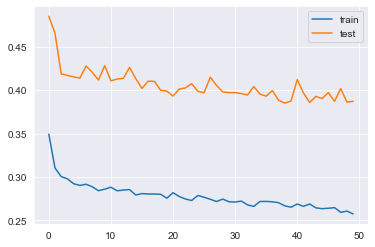

In [44]:
plt.plot(history_final.history['loss'], label='train')
plt.plot(history_final.history['val_loss'], label='test')
plt.legend()
plt.show()

> **Result documentation final model:**<br>
The final model with 
- an LSTM layer (as input layer), 
- a dropout layer with 30 %, 
- a dense layer as output layer, 
- a Nadam optimizer, 
- a learning rate of 0.01  
>
>in our case shows the best results (0.385).  
>
>The optimal number of epochs is in this case 39. 

With the end_run command we stop the recording of the actual Keras model.

In [45]:
mlflow.end_run()

## Project Evaluation

### Plotting

#### Preparation of Prediction Data for Baseline Model

The prediction values based on the final model are represented by following array:

In [133]:
test_pred[:10]

array([ 1.52565211, -0.1833968 , -0.35470202, -1.31773741,  0.96428124,
       -0.0948241 ,  1.43278755,  0.82098009, -0.10044902,  0.71482584])

We generate an array with 1 NaNs (for the first with missing prediction).

In [134]:
arrNaN = np.empty((1))
arrNaN[:] = np.nan
arrNaN

array([nan])

We create an array with prediction values of LSTM model filled with 21 NaNs at the beginning for the missing predictions.

In [135]:
arrPM10_pred = np.concatenate((arrNaN, test_pred))

In [136]:
arrPM10_pred.shape

(730,)

We now generate a Dataframe with normalized values with prediction values for PM10.

In [137]:
df_baseline_pred_norm = df_test_norm.copy() # deep copy of df_test_norm
df_baseline_pred_norm = df_baseline_pred_norm.rename(columns=dictColumn) 
df_baseline_pred_norm = df_baseline_pred_norm.rename(columns={"PM10": "PM10_baseline"}, errors="raise")
df_baseline_pred_norm['PM10_baseline'] = arrPM10_pred
df_baseline_pred_norm

,Temp,WG,WR,Druck,NO,NO2,Niederschlag,PM10_baseline
0,-1.254509,-0.166667,0.156614,0.060825,3.667839,0.193303,0.00,NaN
1,-1.030060,0.333333,3.221164,-0.003011,0.610815,-0.786323,0.47,1.525652
2,-0.941884,0.500000,0.245503,0.460705,0.720918,0.340645,0.00,-0.183397
3,-0.861723,3.666667,3.779894,-0.610057,-0.175465,-0.271336,0.56,-0.354702
4,-1.014028,2.333333,-8.050794,0.512496,1.648031,1.051306,0.00,-1.317737
...,...,...,...,...,...,...,...,...
725,-0.965932,-0.833333,-8.245503,1.233966,3.667839,0.940092,0.00,-0.165542
726,-0.925852,-0.833333,1.680423,1.403794,3.667839,0.645161,0.00,1.190502
727,-0.837675,0.000000,0.592593,1.839807,0.382409,-0.024578,0.10,-0.019365
728,-0.509018,1.333333,1.172487,1.839807,-0.405354,-0.989247,0.70,-0.040675


Now the nenormalization process is performed.

In [138]:
numBaselineDenorm = robustScaler.inverse_transform(df_baseline_pred_norm)
df_baseline_denorm  = pd.DataFrame(numBaselineDenorm, columns=df_baseline_pred_norm.columns)
df_baseline_denorm

,Temp,WG,WR,Druck,NO,NO2,Niederschlag,PM10_baseline
0,-2.8,1.2,220.0,985.69,54.5570,31.5460,0.00,NaN
1,0.0,1.5,292.4,985.16,14.5864,15.6026,0.47,29.618288
2,1.1,1.6,222.1,989.01,16.0260,33.9440,0.00,13.892474
3,2.1,3.5,305.6,980.12,4.3058,23.9840,0.56,12.316209
4,0.2,2.7,26.1,989.44,28.1480,45.5100,0.00,3.454839
...,...,...,...,...,...,...,...,...
725,0.8,0.8,21.5,995.43,54.5570,43.7000,0.00,14.056767
726,1.3,0.8,256.0,996.84,54.5570,38.9000,0.00,26.534408
727,2.4,1.3,230.3,1000.46,11.6000,28.0000,0.10,15.401813
728,6.5,2.1,244.0,1000.46,1.3000,12.3000,0.70,15.205731


With the reset index function we are able to concate the date to the dataframe.

In [139]:
df_test_date = df_test['Datum']
df_test_date.reset_index(drop=True, inplace=True)
df_baseline_denorm.reset_index(drop=True, inplace=True)

In [140]:
df_baseline_denorm_dated = pd.concat([df_test['Datum'], df_baseline_denorm], axis=1, sort=False)

In [141]:
df_baseline_denorm_dated.head()

,Datum,Temp,WG,WR,Druck,NO,NO2,Niederschlag,PM10_baseline
0,2017-01-01,-2.8,1.2,220.0,985.69,54.5570,31.5460,0.00,NaN
1,2017-01-02,0.0,1.5,292.4,985.16,14.5864,15.6026,0.47,29.618288
2,2017-01-03,1.1,1.6,222.1,989.01,16.0260,33.9440,0.00,13.892474
3,2017-01-04,2.1,3.5,305.6,980.12,4.3058,23.9840,0.56,12.316209
4,2017-01-05,0.2,2.7,26.1,989.44,28.1480,45.5100,0.00,3.454839


In [142]:
df_baseline_denorm_dated.tail()

,Datum,Temp,WG,WR,Druck,NO,NO2,Niederschlag,PM10_baseline
725,2018-12-27,0.8,0.8,21.5,995.43,54.557,43.7,0.0,14.056767
726,2018-12-28,1.3,0.8,256.0,996.84,54.557,38.9,0.0,26.534408
727,2018-12-29,2.4,1.3,230.3,1000.46,11.600,28.0,0.1,15.401813
728,2018-12-30,6.5,2.1,244.0,1000.46,1.300,12.3,0.7,15.205731
729,2018-12-31,6.9,0.7,213.9,1001.15,7.600,21.6,0.9,11.799982


#### Preparation of Prediction Data for LSTM

The prediction values based on the final model are represented by following array:

In [143]:
y_pred_LSTM = model_final.predict(X_test)

This array needs to be reshaped for further processing.

In [144]:
y_pred_LSTM_reshape = y_pred_LSTM.reshape(-1)

We generate an array with 21 NaNs (for the first 21 steps with missing predictions).

In [145]:
arrNaN = np.empty((21))
arrNaN[:] = np.nan
arrNaN

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan])

We create an array with prediction values of LSTM model filled with 21 NaNs at the beginning for the missing predictions.

In [146]:
arrPM10_pred = np.concatenate((arrNaN, y_pred_LSTM_reshape))

In [147]:
arrPM10_pred.shape

(730,)

We now generate a Dataframe with normalized values with prediction values for PM10.

In [148]:
df_LSTM_pred_norm = df_test_norm.copy() # deep copy of df_test_norm
df_LSTM_pred_norm = df_LSTM_pred_norm.rename(columns=dictColumn) 
df_LSTM_pred_norm = df_LSTM_pred_norm.rename(columns={"PM10": "PM10_LSTM"}, errors="raise")
df_LSTM_pred_norm['PM10_LSTM'] = arrPM10_pred
df_LSTM_pred_norm

,Temp,WG,WR,Druck,NO,NO2,Niederschlag,PM10_LSTM
0,-1.254509,-0.166667,0.156614,0.060825,3.667839,0.193303,0.00,NaN
1,-1.030060,0.333333,3.221164,-0.003011,0.610815,-0.786323,0.47,NaN
2,-0.941884,0.500000,0.245503,0.460705,0.720918,0.340645,0.00,NaN
3,-0.861723,3.666667,3.779894,-0.610057,-0.175465,-0.271336,0.56,NaN
4,-1.014028,2.333333,-8.050794,0.512496,1.648031,1.051306,0.00,NaN
...,...,...,...,...,...,...,...,...
725,-0.965932,-0.833333,-8.245503,1.233966,3.667839,0.940092,0.00,-0.001957
726,-0.925852,-0.833333,1.680423,1.403794,3.667839,0.645161,0.00,0.387744
727,-0.837675,0.000000,0.592593,1.839807,0.382409,-0.024578,0.10,0.547509
728,-0.509018,1.333333,1.172487,1.839807,-0.405354,-0.989247,0.70,-0.320759


Now the denormalization process is performed.

In [149]:
numLSTMDenorm = robustScaler.inverse_transform(df_LSTM_pred_norm)
df_LSTM_denorm  = pd.DataFrame(numLSTMDenorm, columns=df_LSTM_pred_norm.columns)
df_LSTM_denorm

,Temp,WG,WR,Druck,NO,NO2,Niederschlag,PM10_LSTM
0,-2.8,1.2,220.0,985.69,54.5570,31.5460,0.00,NaN
1,0.0,1.5,292.4,985.16,14.5864,15.6026,0.47,NaN
2,1.1,1.6,222.1,989.01,16.0260,33.9440,0.00,NaN
3,2.1,3.5,305.6,980.12,4.3058,23.9840,0.56,NaN
4,0.2,2.7,26.1,989.44,28.1480,45.5100,0.00,NaN
...,...,...,...,...,...,...,...,...
725,0.8,0.8,21.5,995.43,54.5570,43.7000,0.00,15.561992
726,1.3,0.8,256.0,996.84,54.5570,38.9000,0.00,19.147827
727,2.4,1.3,230.3,1000.46,11.6000,28.0000,0.10,20.617903
728,6.5,2.1,244.0,1000.46,1.3000,12.3000,0.70,12.628536


With the reset index function we are able to concate the date to the dataframe.

In [150]:
df_test_date = df_test['Datum']
df_test_date.reset_index(drop=True, inplace=True)
df_LSTM_denorm.reset_index(drop=True, inplace=True)

In [151]:
df_LSTM_denorm_dated = pd.concat([df_test['Datum'], df_LSTM_denorm], axis=1, sort=False)

In [152]:
df_LSTM_denorm_dated.head()

,Datum,Temp,WG,WR,Druck,NO,NO2,Niederschlag,PM10_LSTM
0,2017-01-01,-2.8,1.2,220.0,985.69,54.5570,31.5460,0.00,NaN
1,2017-01-02,0.0,1.5,292.4,985.16,14.5864,15.6026,0.47,NaN
2,2017-01-03,1.1,1.6,222.1,989.01,16.0260,33.9440,0.00,NaN
3,2017-01-04,2.1,3.5,305.6,980.12,4.3058,23.9840,0.56,NaN
4,2017-01-05,0.2,2.7,26.1,989.44,28.1480,45.5100,0.00,NaN


In [153]:
df_LSTM_denorm_dated.tail()

,Datum,Temp,WG,WR,Druck,NO,NO2,Niederschlag,PM10_LSTM
725,2018-12-27,0.8,0.8,21.5,995.43,54.557,43.7,0.0,15.561992
726,2018-12-28,1.3,0.8,256.0,996.84,54.557,38.9,0.0,19.147827
727,2018-12-29,2.4,1.3,230.3,1000.46,11.600,28.0,0.1,20.617903
728,2018-12-30,6.5,2.1,244.0,1000.46,1.300,12.3,0.7,12.628536
729,2018-12-31,6.9,0.7,213.9,1001.15,7.600,21.6,0.9,10.369339


#### Plotting

Now we want to plot the particulates values for predictions of baseline and final LSTM model against the true particulates data.

In [154]:
df_test_plot = df_test.copy()
df_test_plot.reset_index(drop=True, inplace=True)

First we plot the data for 2017 and 2018. The true data is represented by the blue line, the LSTM prediction by the yellow line and the baseline predictions by the green line. 

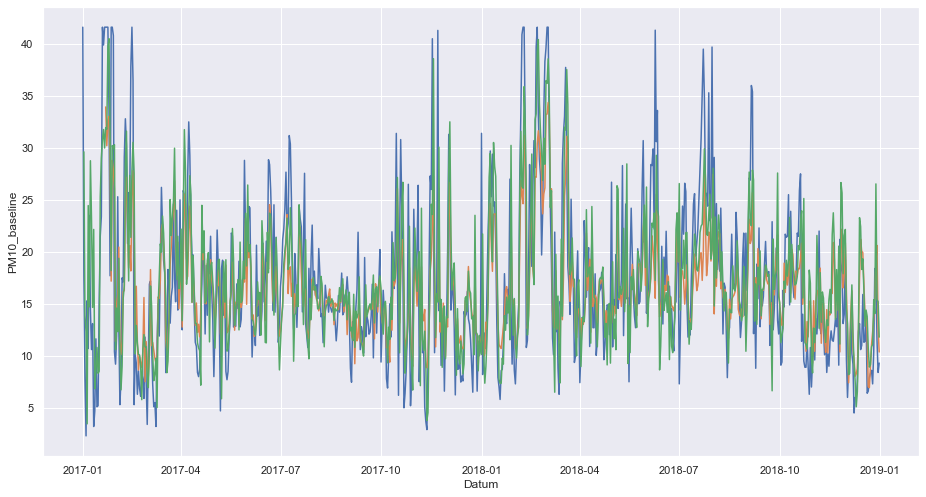

In [155]:
sns.set(rc={'figure.figsize':(15.7,8.27)})

ax=sns.lineplot(x="Datum", y="PM10", data=df_test_plot)
ax=sns.lineplot(x="Datum", y="PM10_LSTM", data=df_LSTM_denorm_dated)
ax=sns.lineplot(x="Datum", y="PM10_baseline", data=df_baseline_denorm_dated)

Next we zoom into the period of 01 February 2017 to 31 March 2017.  
The true data is represented by the blue line, the LSTM prediction by the yellow line and the baseline predictions by the green line. 

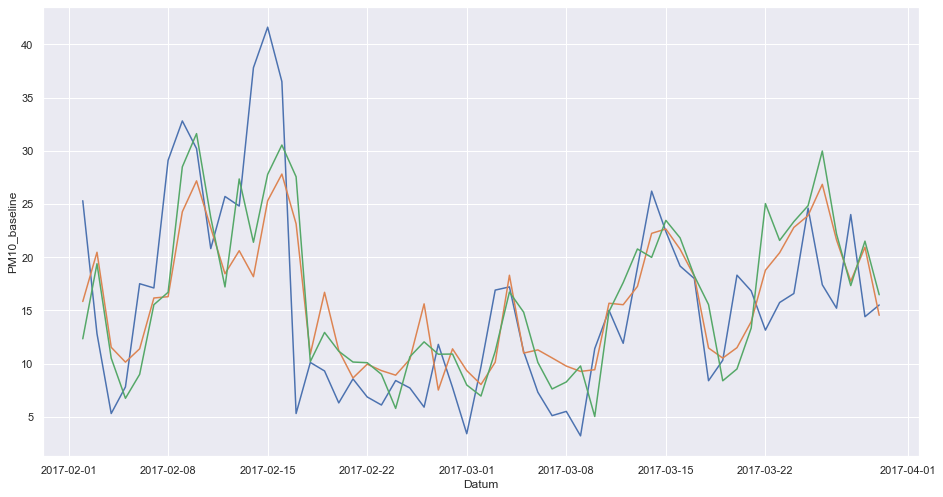

In [156]:
sns.set(rc={'figure.figsize':(15.7,8.27)})

ax=sns.lineplot(x="Datum", y="PM10", data=df_test_plot[(df_test_plot["Datum"] > '2017-02-01 00:00:00')&(df_test_plot["Datum"] < '2017-03-31 00:00:00')])
ax=sns.lineplot(x="Datum", y="PM10_LSTM", data=df_LSTM_denorm_dated[(df_LSTM_denorm_dated["Datum"] > '2017-02-01 00:00:00')&(df_LSTM_denorm_dated["Datum"] < '2017-03-31 00:00:00')])
ax=sns.lineplot(x="Datum", y="PM10_baseline", data=df_baseline_denorm_dated[(df_baseline_denorm_dated["Datum"] > '2017-02-01 00:00:00')&(df_baseline_denorm_dated["Datum"] < '2017-03-31 00:00:00')])

### Project and Result Summary

`Business Understanding`  
In a very early stage we defined the goal of analyzing the predictabilty of particulates data with the help of machine learning.

`Data Understanding and Aquisition`  
Based on our project goals we examined where we can gather the necessary data. 
Also we perfomed an extensive and detailed exploratory data analysis as shown in our [AirQualityStuttgartEDA](AirQualityStuttgartEDA.html) export.

`Data Access and Preparation`  
The data that was found was imported and prepared for further analyzes. 
The preparation consisted of:
- Detection of missing value
- Outliers detection and handling

`Features Selection`  
Based on the preprocessed data the features selection was performed to get the most valuable features for predictions.

`Modeling`  
As a baseline model we chose a linear regression model.  
After this we defined a vanilla LSTM model as starting point for deep learning. 
This model we iteratively improved with manual simulations of different hyperparameters.  
Furthermore we setup the optimal layers architecture for our use case. 
Also we defined a optimizing function to detect the best combination for learning rate and optimizer.  
The led to a final LSTM model with optimized layers and hyperparameters.  
We compared the results of the divers models based on the mean squared error (MSE). 
Our final LSTM model showed the best results for our use case in terms of MSE. 

> ***Results***
> 
> The final LSTM model shows an MSE of ca. 0.385 which corresponds to an root mean squared error of 0.620. As the test data for particulates has a standard deviation of 0.864 we can say that the model is able to predict data - even better than the baseline model.  
> 
> Anyway we realized that the performance of our model is not as good as expected at the beginning of the project. Moreover, the traing and test results were unstable over the time. We also saw that in some trials with less data the model performce seemed to increase. The reasons might be that the features are not fully appropriate to predict the data.  
> 
> Also we saw that the correlations are not high enough.  The feature that we hoped to be able to impact the predictions best, the traffic volume, showed very low correlatons and mutual information so that we had to delete it from further analysis. 
> 
> If continuing the project we would search better traffic data, if possible directly from the measuring station Neckartor. Furthermore we would additionallly transform the input data Wind Direction. This feature has a hugh impact to our prediction target, but the way it is measured and recorded is not suitable for our prediction models (e.g. define cardinal directions as classes).
> 
> Finally we would investigate how we can get data with a smaller amount of missing data in order to avoid imputing data which might lead to distortion and bias.
> 
> 

# Deployment / Outlook

At this place the deployment would take placae.  
In our project we will not implement a deployment process.  
A possible deployment process could foresee following tasks:
- Setup of a cloud environment (e.g. GCP)
- Setup and run of virtuals machines (with the use of GPU for performance improvement)
- Installation Anaconda and Jupyter Notebook
- Deployment of our script in Jupyter Notebook
- Develop and deployment of a scraping script to get the daily input data for prediction
- Development of a cron job to start the training and prediction session
- Design a deshbord to report daily forecasting results